In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

from coinbase_connect import *
from historical_data import *

client = get_client()

c:\Users\ilyes\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ilyes\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [13]:
df = get_candles_data(granularity=300)

Accuracy: 0.5116202133818543


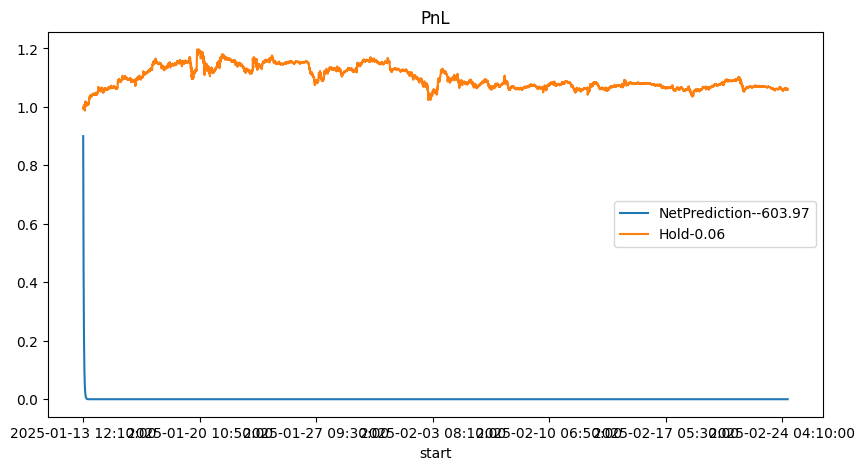

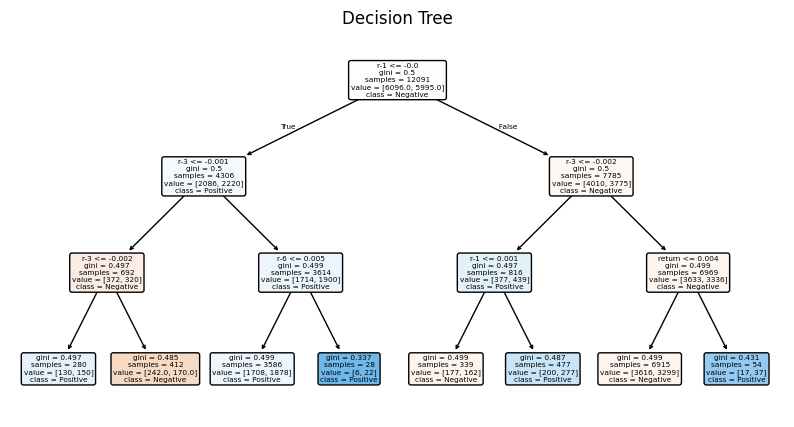

Liquidations:


,max_dd_fees,return_fees
start,,
2025-01-20 17:05:00,-0.045071,-0.012736


In [14]:
df_mom = df.copy()
df_mom["return"] = df_mom["close"] / df_mom["open"] - 1
df_mom["long_dd"] = df_mom["low"] / df_mom["open"] - 1
df_mom["short_dd"] = df_mom["high"] / df_mom["open"] - 1
df_mom = df_mom[["return", "long_dd", "short_dd"]]

fee = 0.01
lev = 50
risk = 0.1

for k in range(1,11):
    df_mom[f"r-{k}"] = df_mom["return"].shift(k)
df_mom['r+1'] = (df_mom['return'].shift(-1) > 0).astype(int)

df_mom.dropna(inplace=True)

X = df_mom.drop(columns=['r+1', "long_dd", "short_dd"])
y = df_mom['r+1']
size = len(df_mom) // 2
X_train, X_test = X[:size], X[size:]
y_train, y_test = y[:size], y[size:]

clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = pd.Series(clf.predict(X_test), index=X_test.index)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
df_mom['prediction'] = np.nan
df_mom.loc[y_pred.index, 'prediction'] = y_test

df_mom['return_long_fees'] = df_mom['return']*(1-fee)-2*fee
df_mom['long_dd_fees'] = df_mom['long_dd']*(1-fee)-2*fee
df_mom['return_short_fees'] = df_mom['return']*(1+fee)+2*fee
df_mom['short_dd_fees'] = df_mom['short_dd']*(1+fee)+2*fee

df_mom['s_pred'] = np.where(df_mom['prediction'] == 1, lev*risk, -lev*risk)
df_mom['return_fees'] = np.where((df_mom['prediction'] == 1).shift(1), df_mom['return_long_fees'], df_mom['return_short_fees'])
df_mom['max_dd'] = np.where((df_mom['prediction'] == 1).shift(1), df_mom['long_dd'], df_mom['short_dd'])
df_mom['max_dd_fees'] = np.where((df_mom['prediction'] == 1).shift(1), df_mom['long_dd_fees'], df_mom['short_dd_fees'])
df_mom['pred_return'] = df_mom['s_pred'].shift(1) * (df_mom['return'])
df_mom['pred_return'] = np.where(df_mom['s_pred'].shift(1)*df_mom['max_dd']<-risk, -risk, df_mom['pred_return'])
df_mom['net_pred_return'] = df_mom['s_pred'].shift(1) * (df_mom['return_fees'])
df_mom['net_pred_return'] = np.where(df_mom['s_pred'].shift(1)*df_mom['max_dd_fees']<-risk, -risk, df_mom['net_pred_return'])

df_mom.dropna(inplace=True)

plt.figure(figsize=(10,5))
(1+df_mom["net_pred_return"]).cumprod().plot(label=f"NetPrediction-{round(df_mom['net_pred_return'].mean() / df_mom['net_pred_return'].std() * np.sqrt(252),2)}")
# (1+df_mom["pred_return"]).cumprod().plot(label=f"Prediction-{round(df_mom['pred_return'].mean() / df_mom['pred_return'].std() * np.sqrt(252),2)}")
(1+df_mom["return"]).cumprod().plot(label=f"Hold-{round(df_mom['return'].mean() / df_mom['return'].std() * np.sqrt(252),2)}")
plt.title('PnL')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=['Negative', 'Positive'], rounded=True)
plt.title("Decision Tree")
plt.show()

print("Liquidations:")
liquidations = df_mom[df_mom["pred_return"] == -risk][["max_dd_fees", "return_fees"]]
liquidations

In [15]:
df_mom[["return", "net_pred_return"]]

,return,net_pred_return
start,,
2025-01-13 12:10:00,-0.001851,-0.1
2025-01-13 12:15:00,-0.000124,-0.1
2025-01-13 12:20:00,-0.001400,-0.1
2025-01-13 12:25:00,0.000118,-0.1
2025-01-13 12:30:00,-0.001512,-0.1
...,...,...
2025-02-24 11:20:00,0.001177,-0.1
2025-02-24 11:25:00,0.001982,-0.1
2025-02-24 11:30:00,-0.000080,-0.1
